In [328]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as sts

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, auc, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils import class_weight
from sklearn.preprocessing import label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer


from scipy import stats
from prettytable import PrettyTable

In [329]:
data = pd.read_csv('data.csv')

Function for scores and ROC curve with corss-validation

In [330]:
def scores(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    return accuracy, precision, recall, f1

In [331]:

def perso_roc(test, X, y):
    y_pred_proba_cv = cross_val_predict(test, X, y, cv=5, method='predict_proba')

    # Compute the ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = len(np.unique(y))
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve((y == i).astype(int), y_pred_proba_cv[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot the ROC curves for each class
    plt.figure()
    colors = plt.cm.get_cmap('tab10', n_classes)
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], color=colors(i), label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) - OvR')
    plt.legend(loc='lower right')

Feature Selection for RF

In [332]:
X = data.drop('metric_item_label', axis = 1)
y = data['metric_item_label']

In [333]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [334]:
RF = RandomForestClassifier(n_estimators=100)
RF.fit(X_train, y_train)

importances_RF = RF.feature_importances_
sorted_indices = np.argsort(importances_RF)[::-1]
important_RF_10 = sorted_indices[:15]
improtant_RF_features = X.columns[important_RF_10]


Text(0.5, 1.0, 'Feature Selection using RF for metric_item_label')

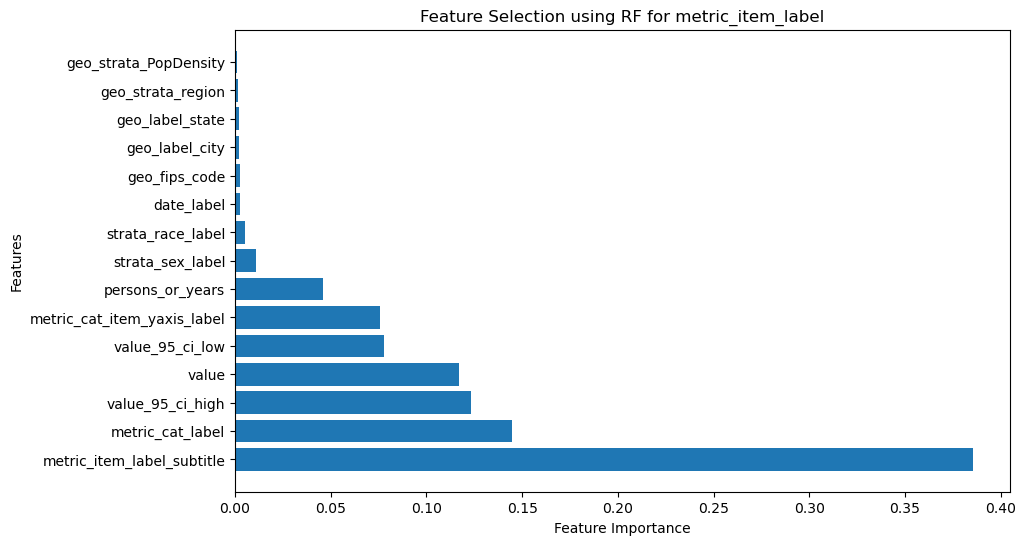

In [335]:
plt.figure(figsize=(10, 6))
plt.barh(range(15), importances_RF[important_RF_10], align='center')
plt.yticks(range(15), improtant_RF_features)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Selection using RF for metric_item_label')

In [336]:
feature_selection_RF = sorted_indices[:8]
feature_selection_RF = X.columns[feature_selection_RF]

feature_selection_RF

Index(['metric_item_label_subtitle', 'metric_cat_label', 'value_95_ci_high',
       'value', 'value_95_ci_low', 'metric_cat_item_yaxis_label',
       'persons_or_years', 'strata_sex_label'],
      dtype='object')

### Random Forest Model

In [337]:
X = data[feature_selection_RF]
y = data['metric_item_label']

In [338]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Changing some Hyperparameters

In [339]:
RF = RandomForestClassifier(n_estimators=3, max_depth=3, max_samples=20)
RF.fit(X_train, y_train)
y_pred_RF = RF.predict(X_test)

In [340]:
y_pred_proba_rf = RF.predict_proba(X_test) 
auc_RF = roc_auc_score(y_test, y_pred_proba_rf, multi_class='ovr')
print(f"Random Forest AUC: {auc_RF}")

Random Forest AUC: 0.9299751294164034


In [341]:
accuracy_RF, precision_RF, recall_RF, f1_RF = scores(y_test, y_pred_RF)

print(f"Accuracy: {accuracy_RF}")
print(f"Precision: {precision_RF}")
print(f"Recall: {recall_RF}")
print(f"F1 Score: {f1_RF}")

Accuracy: 0.7732831608654751
Precision: 0.6693162280851473
Recall: 0.7732831608654751
F1 Score: 0.7101762255535874


Text(0.5, 1.0, 'ROC: RF - Random Forest')

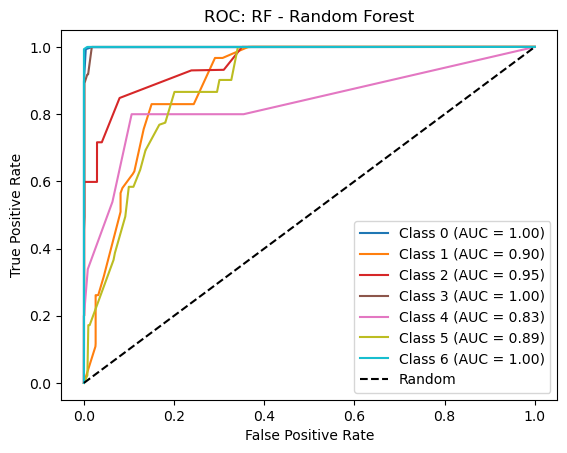

In [342]:
perso_roc(RF, X, y)
plt.title('ROC: RF - Random Forest')

### Logistic Regression Model

In [343]:
LogReg = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=3, penalty='l2', C=100)

The higher the C, the smaller the overfitting. Saga is used for regularization using L2. 

In [344]:
LogReg.fit(X_train, y_train)
y_pred_LogReg = LogReg.predict(X_test)

In [345]:
y_pred_proba_LR = LogReg.predict_proba(X_test) 
auc_LogReg = roc_auc_score(y_test, y_pred_proba_LR, multi_class='ovr')
print(f"Random Forest AUC: {auc_LogReg}")

Random Forest AUC: 0.8846363435122387


In [346]:
accuracy_LogReg, precision_LogReg, recall_LogReg, f1_LogReg = scores(y_test, y_pred_LogReg)

print(f"Accuracy: {accuracy_LogReg}")
print(f"Precision: {precision_LogReg}")
print(f"Recall: {recall_LogReg}")
print(f"F1 Score: {f1_LogReg}")

Accuracy: 0.5717779868297271
Precision: 0.4556383630208187
Recall: 0.5717779868297271
F1 Score: 0.480416766387606


Text(0.5, 1.0, 'ROC: RF - Logistic Regression')

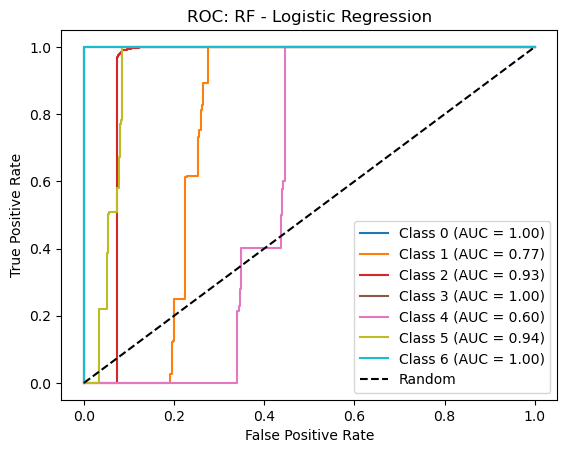

In [347]:
perso_roc(LogReg, X, y)
plt.title('ROC: RF - Logistic Regression')

### Decision Tree Model

In [348]:
DT = DecisionTreeClassifier(max_depth=3, min_samples_split=10, max_features=3)
DT.fit(X_train ,y_train)

y_pred_DT = DT.predict(X_test)

In [349]:
y_pred_proba_DT = DT.predict_proba(X_test) 
auc_DT = roc_auc_score(y_test, y_pred_proba_DT, multi_class='ovr')
print(f"Random Forest AUC: {auc_DT}")

Random Forest AUC: 0.9099497819293366


In [350]:
accuracy_DT, precision_DT, recall_DT, f1_DT = scores(y_test, y_pred_DT)

print(f"Accuracy: {accuracy_DT}")
print(f"Precision: {precision_DT}")
print(f"Recall: {recall_DT}")
print(f"F1 Score: {f1_DT}")

Accuracy: 0.7757290686735654
Precision: 0.6825669897949532
Recall: 0.7757290686735654
F1 Score: 0.7099087364374288


Text(0.5, 1.0, 'ROC: RF - Decision Tree')

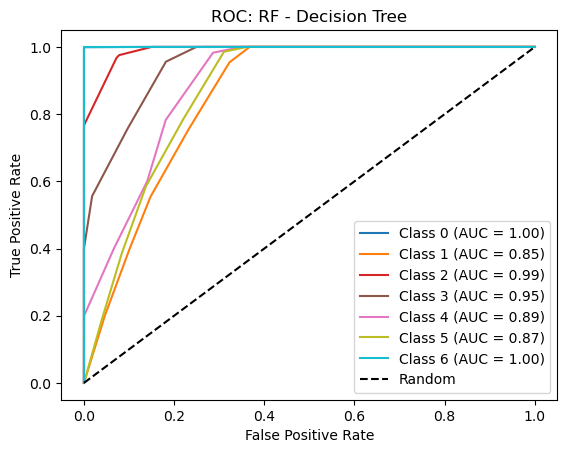

In [351]:
perso_roc(DT, X, y)
plt.title('ROC: RF - Decision Tree')

### Using KNN model

In [352]:
knn = KNeighborsClassifier(n_neighbors=5000, algorithm='kd_tree')

knn.fit(X_train, y_train)
auc_knn = roc_auc_score(y_test, y_pred_proba_DT, multi_class='ovr')

y_pred_knn = knn.predict(X_test)

In [353]:
accuracy_knn, precision_knn, recall_knn, f1_knn = scores(y_test, y_pred_knn)

print(f"Accuracy: {accuracy_knn}")
print(f"Precision: {precision_knn}")
print(f"Recall: {recall_knn}")
print(f"F1 Score: {f1_knn}")


Accuracy: 0.890310442144873
Precision: 0.8517490575703826
Recall: 0.890310442144873
F1 Score: 0.8634498854318358


Text(0.5, 1.0, 'ROC: RF - K Nearest Neighbour')

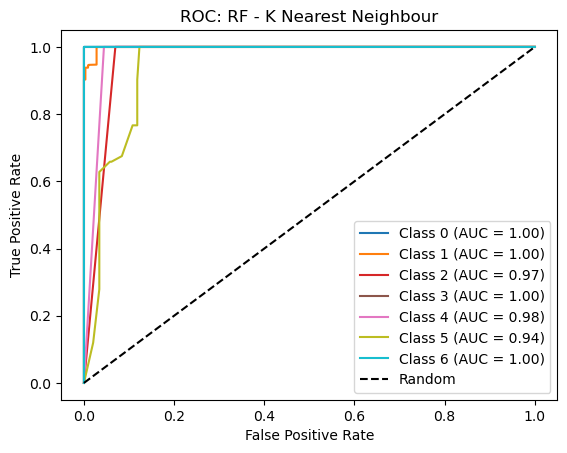

In [354]:
perso_roc(knn, X, y)
plt.title('ROC: RF - K Nearest Neighbour')

### Scores

In [355]:
model_names = ['RF', 'LogReg', 'SVC', 'DT']
accuracy_scores = [accuracy_RF, accuracy_LogReg, accuracy_knn, accuracy_DT]
precision_scores = [precision_RF, precision_LogReg, precision_knn, precision_DT]
recall_scores = [recall_RF, recall_LogReg, recall_knn, recall_DT]
f1_scores = [f1_RF, f1_LogReg, f1_knn, f1_DT]

metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

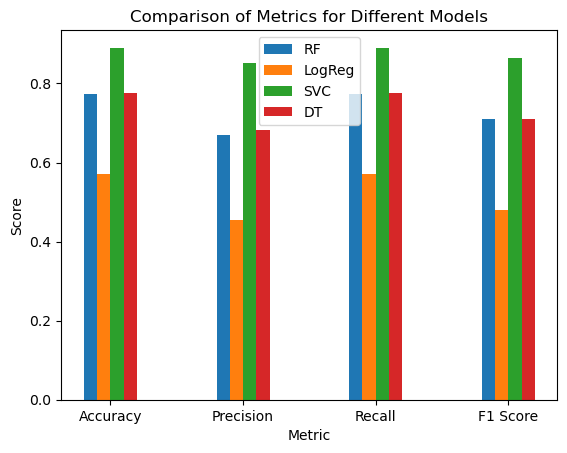

In [356]:
x = np.arange(len(metric_names))

bar_width = 0.1

fig, ax = plt.subplots()

for i, model_name in enumerate(model_names):
    model_scores = [accuracy_scores[i], precision_scores[i], recall_scores[i], f1_scores[i]]
    bar_positions = x + (i * bar_width)
    ax.bar(bar_positions, model_scores, bar_width, label=model_name)

ax.set_xlabel('Metric')
ax.set_ylabel('Score')
ax.set_title('Comparison of Metrics for Different Models')
ax.set_xticks(x + (bar_width * 1.5))
ax.set_xticklabels(metric_names)
ax.legend()

In [357]:
models = ['Random Forest', 'Decision Tree', 'Logistic Regression', 'KNN']
auc_values = [auc_RF, auc_DT, auc_LogReg, auc_knn]

Random Forest AUC: 0.9709708879919126
Decision Tree AUC: 0.9793447843849404
Logistic Regression AUC: 0.8974772287263338
KNN AUC: 0.9099497819293366


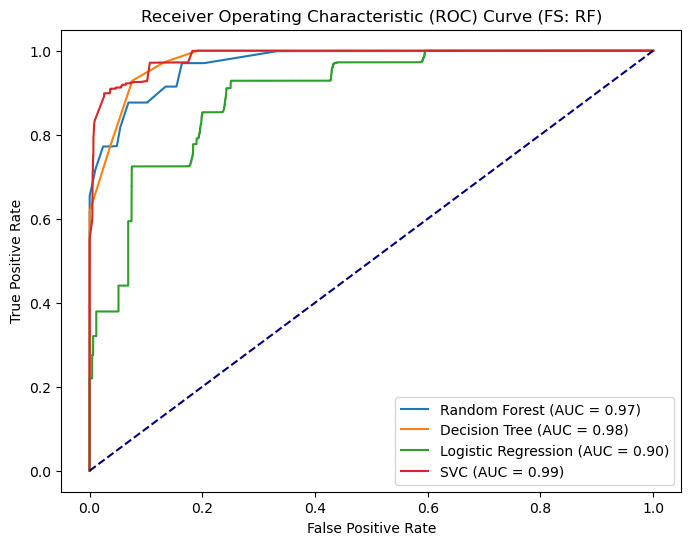

In [358]:
# Random Forest
y_pred_rf = RF.predict_proba(X_test)  # Assuming rf is your trained Random Forest model
fpr_rf, tpr_rf, _ = roc_curve(label_binarize(y_test, classes=np.unique(y_test)).ravel(), y_pred_rf.ravel())
auc_rf = auc(fpr_rf, tpr_rf)
print(f"Random Forest AUC: {auc_rf}")

# Decision Tree
y_pred_dt = DT.predict_proba(X_test)  # Assuming dt is your trained Decision Tree model
fpr_dt, tpr_dt, _ = roc_curve(label_binarize(y_test, classes=np.unique(y_test)).ravel(), y_pred_dt.ravel())
auc_dt = auc(fpr_dt, tpr_dt)
print(f"Decision Tree AUC: {auc_dt}")

# Logistic Regression
y_pred_lr = LogReg.predict_proba(X_test)  # Assuming lr is your trained Logistic Regression model
fpr_lr, tpr_lr, _ = roc_curve(label_binarize(y_test, classes=np.unique(y_test)).ravel(), y_pred_lr.ravel())
auc_lr = auc(fpr_lr, tpr_lr)
print(f"Logistic Regression AUC: {auc_lr}")

# SVC
decision_scores_svc = knn.predict_proba(X_test)
fpr_knn, tpr_knn, _ = roc_curve(label_binarize(y_test, classes=np.unique(y_test)).ravel(), decision_scores_svc.ravel())
auc_svc = auc(fpr_knn, tpr_knn)
print(f"KNN AUC: {auc_knn}")


# Plotting the ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.2f})")
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {auc_dt:.2f})")
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {auc_lr:.2f})")
plt.plot(fpr_knn, tpr_knn, label=f"SVC (AUC = {auc_svc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (FS: RF)')
plt.legend(loc='lower right')
